### Metrics to beat:
```

Classification Metrics Report
-----------------------------
Accuracy:  0.8770
Precision: 0.8136
Recall:    0.8091
F1 Score:  0.8114
```

In [1]:
# Basics
import pandas as pd
import numpy as np

# Visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import psycopg2 as pg
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                             precision_score, recall_score, f1_score)

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from plot_cm import plot_cm

In [2]:
# Postgres info to connect
connection_args = {
    'host': 'localhost',             # Connecting to _local_ version of psql
    'dbname': 'twitter_accounts',    # DB with Twitter info
    'port': 5432                     # port we opened on AWS
}

connection = pg.connect(**connection_args)

In [101]:
q = '''
SELECT * 
FROM human_bots
LIMIT 5
'''

pd.read_sql(q, connection)

,index,created_at,default_profile,default_profile_image,acct_description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,acct_location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,756119643622735875,en,"Birmingham, AL",None,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,464781334,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human


## Data Setup

Using the same format from the Twitter Bot Detection project

In [3]:
raw_df = pd.read_sql('SELECT * FROM human_bots', connection)

In [113]:
# q = '''
# SELECT (CASE WHEN account_type = 'bot' THEN 1 ELSE 0 END) as bot,
#         (CASE WHEN verified = 'True' then 1 ELSE 0 END) as verified,
#         (CASE WHEN geo_enabled = 'True' then 1 ELSE 0 END) as geo_enabled,
#         (CASE WHEN default_profile = 'True' then 1 ELSE 0 END) as default_profile,
#         (CASE WHEN default_profile_image = 'True' then 1 ELSE 0 END) as default_profile_image,
#         account_age_days,
#         favourites_count,
#         followers_count,
#         friends_count,
#         statuses_count,
#         average_tweets_per_day,
#         ROUND((followers_count / account_age_days), 4) as avg_daily_followers,
#         ROUND((friends_count / account_age_days), 4) as avg_daily_friends,
#         ROUND((favourites_count / account_age_days), 4) as avg_daily_favorites
# FROM human_bots
# LIMIT 5
# '''

# pd.read_sql(q, connection)

,bot,verified,geo_enabled,default_profile,default_profile_image,account_age_days,favourites_count,followers_count,friends_count,statuses_count,average_tweets_per_day,avg_daily_followers,avg_daily_friends,avg_daily_favorites
0,1,0,0,0,0,1403,4,1589,4,11041,7.870,1.0,0.0,0.0
1,0,0,0,0,0,1379,536,860,880,252,0.183,0.0,0.0,0.0
2,0,0,1,0,0,1159,3307,172,594,1001,0.864,0.0,0.0,2.0
3,0,0,1,1,0,1489,8433,517,633,1324,0.889,0.0,0.0,5.0
4,0,1,1,0,0,3138,88,753678,116,4202,1.339,240.0,0.0,0.0


In [ ]:
features = ['verified', 
            #'created_at',
            'hour_created',
            #'lang',
            #'acct_location',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            #'favs_rate'
           ]

In [4]:
# drop funny index column
raw_df.drop(columns=['index'], inplace=True)

# Binary classifications for bots and boolean values
raw_df['bot'] = raw_df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile_image'] = raw_df['default_profile_image'].astype(int)
raw_df['geo_enabled'] = raw_df['geo_enabled'].astype(int)
raw_df['verified'] = raw_df['verified'].astype(int)

# datetime conversion
raw_df['created_at'] = pd.to_datetime(raw_df['created_at'])
# hour created
raw_df['hour_created'] = pd.to_datetime(raw_df['created_at']).dt.hour

In [5]:
df = raw_df[['bot', 'screen_name', 'created_at', 'hour_created', 'verified', 'acct_location', 'geo_enabled', 'lang', 
             'default_profile', 'default_profile_image', 'favourites_count', 'followers_count', 'friends_count', 
             'statuses_count', 'average_tweets_per_day', 'account_age_days']]

del raw_df

In [6]:
# Interesting features to look at: 
df['avg_daily_followers'] = np.round((df['followers_count'] / df['account_age_days']), 3)
df['avg_daily_friends'] = np.round((df['followers_count'] / df['account_age_days']), 3)
df['avg_daily_favorites'] = np.round((df['followers_count'] / df['account_age_days']), 3)

# Log transformations for highly skewed data
df['friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df['favs_log'] = np.round(np.log(1 + df['favourites_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_day']), 3)

# Possible interactive features
df['network'] = np.round(df['friends_log'] * df['followers_log'], 3)
df['tweet_to_followers'] = np.round(np.log( 1 + df['statuses_count']) * np.log(1+ df['followers_count']), 3)

# Log-transformed daily acquisition metrics for dist. plots
df['follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['account_age_days'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)

In [7]:
df.head()

,bot,screen_name,created_at,hour_created,verified,acct_location,geo_enabled,lang,default_profile,default_profile_image,...,avg_daily_favorites,friends_log,followers_log,favs_log,avg_daily_tweets_log,network,tweet_to_followers,follower_acq_rate,friends_acq_rate,favs_rate
0,1,best_in_dumbest,2016-10-15 21:32:11,21,0,unknown,0,en,0,0,...,1.133,1.609,7.371,1.609,2.183,11.860,68.625,0.757,0.003,0.003
1,0,CJRubinPhoto,2016-11-09 05:01:30,5,0,Estados Unidos,0,en,0,0,...,0.624,6.781,6.758,6.286,0.168,45.826,37.395,0.485,0.494,0.494
2,0,SVGEGENT,2017-06-17 05:34:27,5,0,"Los Angeles, CA",1,en,0,0,...,0.148,6.389,5.153,8.104,0.623,32.923,35.608,0.138,0.414,0.414
3,0,TinkerVHELPK5,2016-07-21 13:32:25,13,0,"Birmingham, AL",1,en,1,0,...,0.347,6.452,6.250,9.040,0.636,40.325,44.932,0.298,0.354,0.354
4,0,JoleonLescott,2012-01-15 16:32:35,16,1,"England, United Kingdom",1,en,0,0,...,240.178,4.762,13.533,4.489,0.850,64.444,112.911,5.486,0.036,0.036


In [ ]:
verified
hour_created

In [114]:
# Feature Selection
features = ['verified', 
            'hour_created',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df[features].to_numpy(dtype='float32')
y = np.ravel(df['bot']).astype('float32')

X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=1234)

In [115]:
print(X.shape, y.shape)

(26206, 15) (26206,)


In [116]:
X.shape[1]

15

In [ ]:
X_val.shape

In [ ]:
y_val.shape

In [9]:
bots = sum([1 for val in y_val if val == 1])
humans = sum([1 for val in y_val if val ==0])

print("Number of humans in val set: ", humans)
print("Number of bots in val set: ", bots)
print(len(y_val))

print(f"Percent bot class: {(bots / len(y_val)):.2f}")

Number of humans in val set:  5279
Number of bots in val set:  2583
7862
Percent bot class: 0.33


## Keras Model

In [135]:
model = keras.Sequential([
    keras.layers.Dense(64, kernel_initializer='normal', activation='relu', input_dim=X.shape[1]),
    keras.layers.Dense(64, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(64, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(128, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(128, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(128, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(128, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(64, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(64, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(64, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(32, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(32, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(32, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(1, kernel_initializer='normal', activation='sigmoid')
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_193 (Dense)            (None, 64)                1024      
_________________________________________________________________
dense_194 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_195 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_196 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_197 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_198 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_199 (Dense)            (None, 128)             

In [136]:
early_stopping = EarlyStopping(
                            monitor='val_accuracy',
                            patience=50,
                            min_delta=0.0005,
                            mode='max',
                            restore_best_weights=True)

history = model.fit(X_train,
                   y_train,
                   epochs=400,
                   batch_size=400,
                   validation_data=(X_val, y_val),
                   verbose=2,
                   callbacks=[early_stopping])

Epoch 1/400
46/46 - 0s - loss: 0.6545 - accuracy: 0.6637 - val_loss: 0.6316 - val_accuracy: 0.6715
Epoch 2/400
46/46 - 0s - loss: 0.6172 - accuracy: 0.6637 - val_loss: 0.6001 - val_accuracy: 0.6715
Epoch 3/400
46/46 - 0s - loss: 0.5995 - accuracy: 0.6649 - val_loss: 0.6042 - val_accuracy: 0.6745
Epoch 4/400
46/46 - 0s - loss: 0.5988 - accuracy: 0.6659 - val_loss: 0.6076 - val_accuracy: 0.6715
Epoch 5/400
46/46 - 0s - loss: 0.5936 - accuracy: 0.6771 - val_loss: 0.5832 - val_accuracy: 0.6922
Epoch 6/400
46/46 - 0s - loss: 0.5769 - accuracy: 0.7288 - val_loss: 0.5586 - val_accuracy: 0.7254
Epoch 7/400
46/46 - 0s - loss: 0.5453 - accuracy: 0.7692 - val_loss: 0.5222 - val_accuracy: 0.7853
Epoch 8/400
46/46 - 0s - loss: 0.5100 - accuracy: 0.7925 - val_loss: 0.5208 - val_accuracy: 0.7694
Epoch 9/400
46/46 - 0s - loss: 0.4844 - accuracy: 0.8009 - val_loss: 0.4749 - val_accuracy: 0.8086
Epoch 10/400
46/46 - 0s - loss: 0.4594 - accuracy: 0.8144 - val_loss: 0.4469 - val_accuracy: 0.8294
Epoch 11/

46/46 - 0s - loss: 0.3228 - accuracy: 0.8645 - val_loss: 0.3467 - val_accuracy: 0.8568
Epoch 84/400
46/46 - 0s - loss: 0.3162 - accuracy: 0.8681 - val_loss: 0.3514 - val_accuracy: 0.8517
Epoch 85/400
46/46 - 0s - loss: 0.3178 - accuracy: 0.8645 - val_loss: 0.3520 - val_accuracy: 0.8513
Epoch 86/400
46/46 - 0s - loss: 0.3211 - accuracy: 0.8631 - val_loss: 0.3452 - val_accuracy: 0.8561
Epoch 87/400
46/46 - 0s - loss: 0.3205 - accuracy: 0.8655 - val_loss: 0.3499 - val_accuracy: 0.8559
Epoch 88/400
46/46 - 0s - loss: 0.3131 - accuracy: 0.8699 - val_loss: 0.3491 - val_accuracy: 0.8547
Epoch 89/400
46/46 - 0s - loss: 0.3172 - accuracy: 0.8670 - val_loss: 0.3469 - val_accuracy: 0.8572
Epoch 90/400
46/46 - 0s - loss: 0.3152 - accuracy: 0.8697 - val_loss: 0.3485 - val_accuracy: 0.8533
Epoch 91/400
46/46 - 0s - loss: 0.3201 - accuracy: 0.8677 - val_loss: 0.3510 - val_accuracy: 0.8509
Epoch 92/400
46/46 - 0s - loss: 0.3175 - accuracy: 0.8656 - val_loss: 0.3509 - val_accuracy: 0.8531
Epoch 93/400


Epoch 165/400
46/46 - 0s - loss: 0.2847 - accuracy: 0.8817 - val_loss: 0.3573 - val_accuracy: 0.8611
Epoch 166/400
46/46 - 0s - loss: 0.2830 - accuracy: 0.8840 - val_loss: 0.3571 - val_accuracy: 0.8537
Epoch 167/400
46/46 - 0s - loss: 0.2830 - accuracy: 0.8820 - val_loss: 0.3510 - val_accuracy: 0.8572
Epoch 168/400
46/46 - 0s - loss: 0.2808 - accuracy: 0.8838 - val_loss: 0.3503 - val_accuracy: 0.8577
Epoch 169/400
46/46 - 0s - loss: 0.2777 - accuracy: 0.8868 - val_loss: 0.3505 - val_accuracy: 0.8569
Epoch 170/400
46/46 - 0s - loss: 0.2736 - accuracy: 0.8862 - val_loss: 0.3578 - val_accuracy: 0.8569
Epoch 171/400
46/46 - 0s - loss: 0.2781 - accuracy: 0.8861 - val_loss: 0.3527 - val_accuracy: 0.8578
Epoch 172/400
46/46 - 0s - loss: 0.2726 - accuracy: 0.8890 - val_loss: 0.3568 - val_accuracy: 0.8536
Epoch 173/400
46/46 - 0s - loss: 0.2782 - accuracy: 0.8859 - val_loss: 0.3607 - val_accuracy: 0.8569
Epoch 174/400
46/46 - 0s - loss: 0.2725 - accuracy: 0.8880 - val_loss: 0.3560 - val_accurac

In [124]:
def score_training_model(model):
    y_pred_probs = model.predict(X_val, verbose=1)
    y_pred_bool = model.predict_classes(X_val, verbose=1)
    
    print("Classification Metrics Report")
    print("-----------------------------")
    print('Accuracy:  {:.4f}'.format(accuracy_score(y_val, y_pred_bool)))
    print('Precision: {:.4f}'.format(precision_score(y_val, y_pred_bool)))
    print('Recall:    {:.4f}'.format(recall_score(y_val, y_pred_bool)))
    print('F1 Score:  {:.4f}'.format(f1_score(y_val, y_pred_bool)))
    print('')
    print(classification_report(y_val, y_pred_bool))
    print('')
    cm = confusion_matrix(y_pred_bool, y_val)
    labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    categories = ['Human', 'Bot']
    plot_cm(cm,
            target_names=categories,
            title='Confusion matrix',
            cmap=None,
            normalize=False)
    
def plot_training_history(history_dict):
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    
    plt.figure(figsize=(10, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()    

246/246 [==============================] - 0s 402us/step
Classification Metrics Report
-----------------------------
Accuracy:  0.8630
Precision: 0.8426
Recall:    0.7170
F1 Score:  0.7747

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      5279
         1.0       0.84      0.72      0.77      2583

    accuracy                           0.86      7862
   macro avg       0.86      0.83      0.84      7862
weighted avg       0.86      0.86      0.86      7862




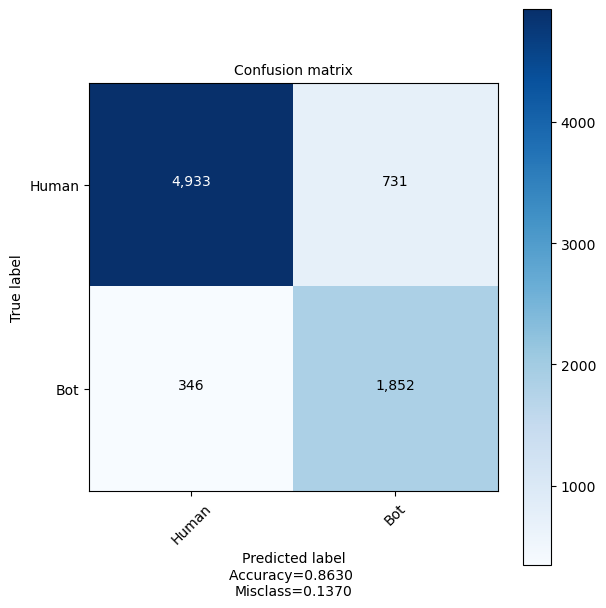

In [137]:
score_training_model(model)

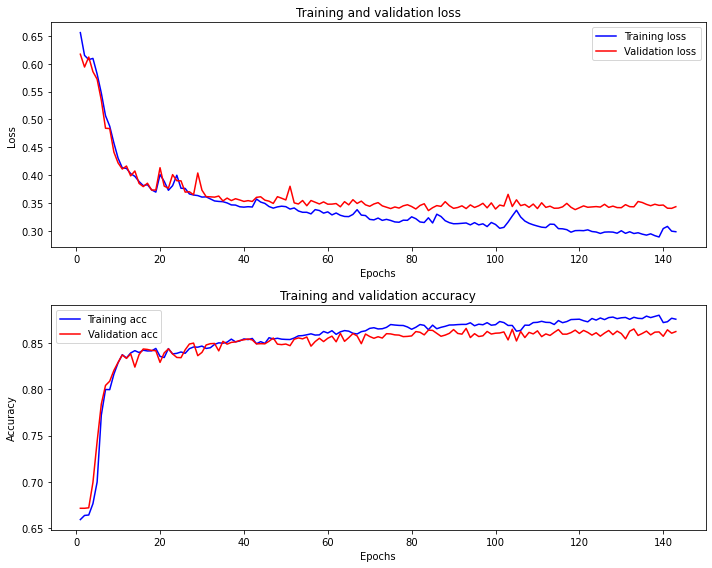

In [131]:
plot_training_history(history.history)

## Another Model

In [172]:
model = keras.Sequential([
    keras.layers.Dense(64, kernel_initializer='normal', activation='relu', input_dim=X.shape[1]),
    keras.layers.Dense(64, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(128, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(128, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(64, kernel_initializer='normal', activation='relu'),
    keras.layers.Dense(1, kernel_initializer='normal', activation='sigmoid')
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_248 (Dense)            (None, 64)                1024      
_________________________________________________________________
dense_249 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_250 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_251 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_252 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_253 (Dense)            (None, 1)                 65        
Total params: 38,337
Trainable params: 38,337
Non-trainable params: 0
_________________________________________________

In [173]:
early_stopping = EarlyStopping(
                            monitor='val_accuracy',
                            patience=50,
                            min_delta=0.0005,
                            mode='max',
                            restore_best_weights=True)

history = model.fit(X_train,
                   y_train,
                   epochs=500,
                   batch_size=300,
                   validation_data=(X_val, y_val),
                   verbose=2,
                   callbacks=[early_stopping])

Epoch 1/500
62/62 - 0s - loss: 5.5586 - accuracy: 0.6174 - val_loss: 1.9021 - val_accuracy: 0.6715
Epoch 2/500
62/62 - 0s - loss: 1.1033 - accuracy: 0.6334 - val_loss: 1.4381 - val_accuracy: 0.6744
Epoch 3/500
62/62 - 0s - loss: 1.1845 - accuracy: 0.6623 - val_loss: 1.1346 - val_accuracy: 0.7041
Epoch 4/500
62/62 - 0s - loss: 0.8380 - accuracy: 0.6858 - val_loss: 0.6529 - val_accuracy: 0.7114
Epoch 5/500
62/62 - 0s - loss: 0.6381 - accuracy: 0.6948 - val_loss: 0.5841 - val_accuracy: 0.7080
Epoch 6/500
62/62 - 0s - loss: 0.6079 - accuracy: 0.6986 - val_loss: 0.5719 - val_accuracy: 0.7076
Epoch 7/500
62/62 - 0s - loss: 0.6790 - accuracy: 0.7048 - val_loss: 0.8020 - val_accuracy: 0.7222
Epoch 8/500
62/62 - 0s - loss: 1.0783 - accuracy: 0.7026 - val_loss: 0.7238 - val_accuracy: 0.7265
Epoch 9/500
62/62 - 0s - loss: 1.2927 - accuracy: 0.7099 - val_loss: 0.6379 - val_accuracy: 0.7212
Epoch 10/500
62/62 - 0s - loss: 0.7459 - accuracy: 0.7079 - val_loss: 0.5511 - val_accuracy: 0.7272
Epoch 11/

Epoch 84/500
62/62 - 0s - loss: 0.3561 - accuracy: 0.8552 - val_loss: 0.3767 - val_accuracy: 0.8490
Epoch 85/500
62/62 - 0s - loss: 0.3548 - accuracy: 0.8586 - val_loss: 0.3715 - val_accuracy: 0.8521
Epoch 86/500
62/62 - 0s - loss: 0.3558 - accuracy: 0.8526 - val_loss: 0.3697 - val_accuracy: 0.8531
Epoch 87/500
62/62 - 0s - loss: 0.3395 - accuracy: 0.8641 - val_loss: 0.3635 - val_accuracy: 0.8549
Epoch 88/500
62/62 - 0s - loss: 0.3373 - accuracy: 0.8625 - val_loss: 0.3666 - val_accuracy: 0.8564
Epoch 89/500
62/62 - 0s - loss: 0.3359 - accuracy: 0.8640 - val_loss: 0.3698 - val_accuracy: 0.8533
Epoch 90/500
62/62 - 0s - loss: 0.3417 - accuracy: 0.8602 - val_loss: 0.3704 - val_accuracy: 0.8546
Epoch 91/500
62/62 - 0s - loss: 0.3327 - accuracy: 0.8660 - val_loss: 0.3771 - val_accuracy: 0.8493
Epoch 92/500
62/62 - 0s - loss: 0.3367 - accuracy: 0.8635 - val_loss: 0.4991 - val_accuracy: 0.8264
Epoch 93/500
62/62 - 0s - loss: 0.3340 - accuracy: 0.8655 - val_loss: 0.3651 - val_accuracy: 0.8563


Epoch 166/500
62/62 - 0s - loss: 0.2937 - accuracy: 0.8817 - val_loss: 0.3675 - val_accuracy: 0.8569
Epoch 167/500
62/62 - 0s - loss: 0.2919 - accuracy: 0.8820 - val_loss: 0.3762 - val_accuracy: 0.8588
Epoch 168/500
62/62 - 0s - loss: 0.3127 - accuracy: 0.8751 - val_loss: 0.3929 - val_accuracy: 0.8430
Epoch 169/500
62/62 - 0s - loss: 0.3139 - accuracy: 0.8765 - val_loss: 0.3845 - val_accuracy: 0.8553
Epoch 170/500
62/62 - 0s - loss: 0.3126 - accuracy: 0.8735 - val_loss: 0.3708 - val_accuracy: 0.8556
Epoch 171/500
62/62 - 0s - loss: 0.3018 - accuracy: 0.8781 - val_loss: 0.3635 - val_accuracy: 0.8542


246/246 [==============================] - 0s 321us/step
Classification Metrics Report
-----------------------------
Accuracy:  0.8608
Precision: 0.8804
Recall:    0.6671
F1 Score:  0.7590

              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90      5279
         1.0       0.88      0.67      0.76      2583

    accuracy                           0.86      7862
   macro avg       0.87      0.81      0.83      7862
weighted avg       0.86      0.86      0.86      7862




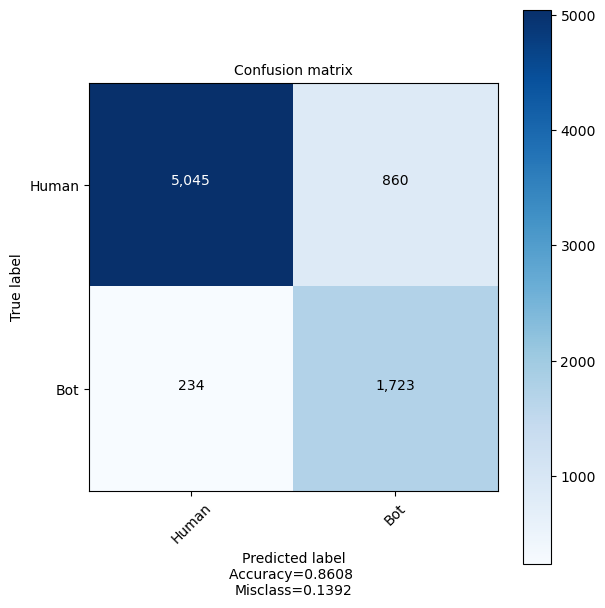

In [174]:
score_training_model(model)

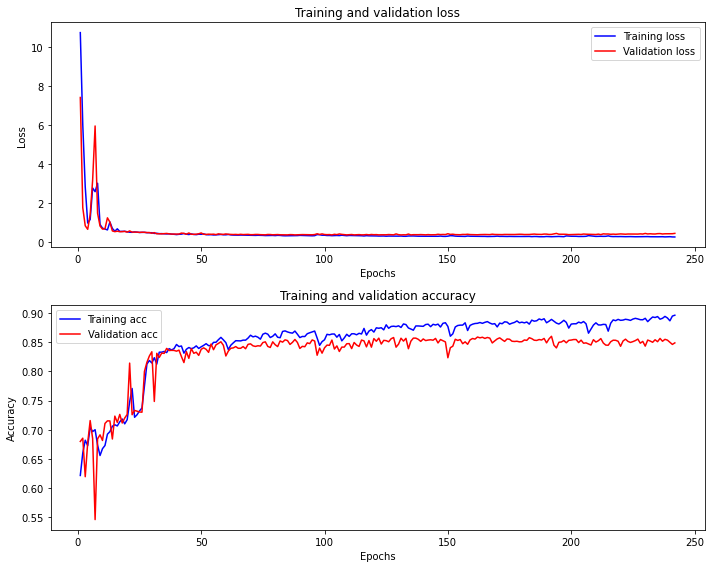

In [168]:
plot_training_history(history.history)